In [5]:
import pandas as pd
import numpy as np
np.random.seed(2700)

Я заниюмаюсь управлением товародвижения в федеральной сети ювелирных магазинов (900 магазинов). Отвечаю за изделия из золота. В данной работе хочу применить машинное обучение для:

- прогноза продаж ассортимента определенного типа для каждого торгового объекта(магазина) в отдельности
- выявление главных признаков торгового объекта(магазина), котороые влияют на продажи ассортимента определенного типа

Делать это буду на примере мусульманских подвесов.
Для анализа буду использовать данные по продажам мусульманских подвесов из серебра, т.к. они присутствуют почти в каждом магазине.
Практическая польза

In [6]:
# Загружаю датасет с продажами серебра и золота 
name = r'C:\нетология\muslim.xlsx'
mus_sales = pd.read_excel(name, sheet_name='олап', skiprows=10, usecols=[0,2,3], names=['id','585_msale','925_msale'])

# Убираем пустые значения после 'Общий итог'
lst = mus_sales['id'].tolist()
mus_sales = mus_sales.drop(axis=0,index=np.arange(lst.index('Общий итог'),len(lst)))
mus_sales.tail()

,id,585_msale,925_msale
893,92,0.0,1.0
894,925,0.0,2.0
895,955,1.0,8.0
896,96,7.0,13.0
897,99,12.0,14.0


In [7]:
name = r'C:\нетология\muslim.xlsx'
mus_stock = pd.read_excel(name, sheet_name='олап', skiprows=10, usecols=[7,9,10],names=['id','585_mstock','925_mstock'])

# Убираем пустые значения
lst = mus_stock['id'].tolist()
mus_stock = mus_stock.drop(axis=0,index=np.arange(lst.index('Общий итог'),len(lst)))

# Убираем магазины с нулевыми остатками
mus_stock['sum'] = mus_stock['585_mstock'] + mus_stock['925_mstock']
mus_stock = mus_stock[(mus_stock['sum'] > 0)]
del mus_stock['sum']
mus_stock.tail()

,id,585_mstock,925_mstock
1462,92,26.0,8.0
1463,925,1.0,11.0
1464,955,5.0,10.0
1465,96,22.0,14.0
1468,99,27.0,20.0


In [8]:
# Оставляем склады, где есть остатки золото и серебро одновременно

mus_stock_combined = mus_stock[(mus_stock['585_mstock'] > 5)&(mus_stock['925_mstock'] > 5)].drop(axis=1, labels=['585_mstock','925_mstock'])

# Посмотрим корреляцию в продажах золота и серебра
mus_sales_combined = pd.merge(mus_stock_combined, mus_sales, on='id',how='left').dropna(how='any')
mus_sales_combined[['585_msale','925_msale']].corr().round(decimals=1)

,585_msale,925_msale
585_msale,1.0,0.7
925_msale,0.7,1.0


Коэффицент корреляции между золотом и серебром 0,7. Можно использовать данные по серебру

In [9]:
# Посмотрим есть ли разница в распределении продаж по золоту и серебру
mus_sales_combined.describe().round()

,585_msale,925_msale
count,492.0,492.0
mean,10.0,12.0
std,10.0,12.0
min,0.0,0.0
25%,3.0,5.0
50%,7.0,9.0
75%,14.0,15.0
max,57.0,82.0


Вопросы: 
- нужно ли объединять тц и трц?
- разные размерности и порядок исчисления (продажи и емкость магазина в штуках, зарплата в рублях, доли в процентах)


###### Создаем большой датасет для обучения модели со следующей информацией:

+ id - номер магазина его перед обучением я удалю
+ 925_msale - продажи мусульманских подвесов - целевая переменная
+ type - тип размещения объекта (отдельное здание или торговый центр)
+ city - город или населенный пункт, по этому параметру каждому объекту можно установить признак региона
+ shop_size - вместимость объекта в штуках
+ work_time - время работы объекта в годах 
+ total_sales - общие продажи в штуках за полгода
+ brand - вывеска на магазине(есть несколько брэндов)
+ population - количество жителей в данном населенном пункте 
+ salary - средняя зарплата (distr - в округе,reg - в регионе)
+ mosque - есть или нет в населенном пункте мечеть(по данным из википедии)
+ muslim_per - процент верующих мусульман (distr - в округе,reg - в регионе)
+ rus_per - процент русских по национальности (distr - в округе,reg - в регионе)
+ religion_imp - процент людей, для которых религия играет важную роль в жизни (distr - в округе,reg - в регионе)


###### Откуда брал данные:

+ Численность населения - Оценка численности постоянного населения на 1 января 2018г.Росстат по городам
+ Доля мусульман, процент русских, процент религиозных - Общероссийский опрос МегаФОМ 29 мая – 25 июня 2012 г. по субъектам РФ
+ Доходы населения - Среднемесячная номинальная начисленная заработная плата работников по полному кругу организаций  по субъектам Российской Федерации. Росстат. 2018-2019 г
+ Количество мечетей - википедия статья Ислам в России
+ Данные по долготе/широте/региону получал через GeoPy по городу


Все данные собрал в единую таблицу в EXcel потом загрузил в ноутбук.

Чеченская  и Ингушская республика не участвовала в исследовании МегаФОМ. Поэтому для этих республик инфу пришлось искать отдельно

In [10]:
# Загружаем справочник с характеристиками магазинов и дополнительной информацией по регионам. 
ref_book = pd.read_excel(r'C:\нетология\muslim.xlsx', sheet_name='типы', usecols=list(range(6,27)))
ref_book['id'] = ref_book['id'].astype('float64')
ref_book.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 21 columns):
id                    903 non-null float64
city                  903 non-null object
type                  903 non-null object
shop_size             900 non-null float64
work_time             903 non-null int64
total_sales           899 non-null float64
stock_month           903 non-null int64
brand                 903 non-null object
population            898 non-null float64
salary_reg            898 non-null float64
salary_district       898 non-null float64
mosque                903 non-null int64
muslim_per_reg        898 non-null float64
muslim_per_distr      898 non-null float64
religion_imp_reg      898 non-null float64
religion_imp_distr    898 non-null float64
rus_per_reg           898 non-null float64
rus_per_distr         898 non-null float64
coord                 898 non-null object
district              898 non-null object
region                898 non-null object
dtyp

In [11]:
# Добавляем к продажам подвесов по магазинам всю информацию из справочника
mus_sales = pd.read_excel(name, sheet_name='олап', skiprows=10, usecols=[40,42], names=['id','925_msale'])
raw_df = pd.merge(mus_sales,ref_book,how='left', on='id')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8131 entries, 0 to 8130
Data columns (total 22 columns):
id                    8130 non-null float64
925_msale             8131 non-null int64
city                  4515 non-null object
type                  4515 non-null object
shop_size             4500 non-null float64
work_time             4515 non-null float64
total_sales           4495 non-null float64
stock_month           4515 non-null float64
brand                 4515 non-null object
population            4490 non-null float64
salary_reg            4490 non-null float64
salary_district       4490 non-null float64
mosque                4515 non-null float64
muslim_per_reg        4490 non-null float64
muslim_per_distr      4490 non-null float64
religion_imp_reg      4490 non-null float64
religion_imp_distr    4490 non-null float64
rus_per_reg           4490 non-null float64
rus_per_distr         4490 non-null float64
coord                 4490 non-null object
district           

In [12]:
# Округлим размер и уберем маги, которые работают меньше 4 месяцев 
raw_df['shop_size'] = raw_df['shop_size'].round()
raw_df = raw_df[raw_df['stock_month'] > 4]

In [13]:
# Уберем франчайзинговые магазины - там перекос по ассортименту

raw_df = raw_df[raw_df['type']!='франч']
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4310 entries, 0 to 8129
Data columns (total 22 columns):
id                    4310 non-null float64
925_msale             4310 non-null int64
city                  4310 non-null object
type                  4310 non-null object
shop_size             4310 non-null float64
work_time             4310 non-null float64
total_sales           4310 non-null float64
stock_month           4310 non-null float64
brand                 4310 non-null object
population            4310 non-null float64
salary_reg            4310 non-null float64
salary_district       4310 non-null float64
mosque                4310 non-null float64
muslim_per_reg        4310 non-null float64
muslim_per_distr      4310 non-null float64
religion_imp_reg      4310 non-null float64
religion_imp_distr    4310 non-null float64
rus_per_reg           4310 non-null float64
rus_per_distr         4310 non-null float64
coord                 4310 non-null object
district           

In [14]:
# Уберем магазины со спец ассортиментом, там больше нет мусульманских подвесов
raw_df.where(raw_df.brand != 0, inplace=True)
# Удаляем строки без значений
raw_df.dropna(how='all', inplace=True)

In [15]:
# Корреляция количественных признаков с целевым значением
corr_matrix = raw_df.corr().round(decimals=2)
corr_matrix['925_msale'].sort_values(ascending=False)

925_msale             1.00
muslim_per_reg        0.39
total_sales           0.31
religion_imp_reg      0.29
mosque                0.17
muslim_per_distr      0.15
shop_size             0.14
religion_imp_distr    0.13
salary_reg            0.09
population            0.06
id                    0.04
stock_month           0.03
work_time            -0.10
salary_district      -0.11
rus_per_distr        -0.19
rus_per_reg          -0.36
Name: 925_msale, dtype: float64

In [16]:
# Разделим датафрейм на два, в одном будут собраны региональные признаки, в другом признаки по округам 
# возможно какой то датасет даст более точный результат

drop_distr = [x for x in raw_df.columns.tolist() if '_reg' in x] + ['id','stock_month','coord','region']
drop_reg = [x for x in raw_df.columns.tolist() if '_distr'in x] + ['id','stock_month','coord']

distr_df = raw_df.drop(drop_distr, axis=1)
reg_df = raw_df.drop(drop_reg, axis=1)

In [17]:
distr_df.head()

,925_msale,city,type,shop_size,work_time,total_sales,brand,population,salary_district,mosque,muslim_per_distr,religion_imp_distr,rus_per_distr,district
0,1.0,Астрахань,Стрит,4809.0,12.0,465.0,ab,533925.0,32501.94,1.0,2.937507,12.754090,87.367898,ЮФО
1,1.0,Белгород,Стрит,13135.0,12.0,1899.0,a,391554.0,58083.38,0.0,1.587594,15.818874,93.793375,ЦФО
3,0.0,Ставрополь,Стрит,5378.0,8.0,917.0,a,433931.0,27505.38,0.0,40.394395,29.797887,38.837755,СКФО
4,0.0,Выборг,Стрит,13141.0,8.0,2904.0,b,77400.0,50754.60,0.0,1.059460,13.374155,90.223258,СЗФО
5,3.0,Энгельс,Стрит,7831.0,12.0,1779.0,a,226176.0,32783.10,0.0,12.317776,16.559501,68.107610,ПФО


In [18]:
# проверим сбалансированность категориальных данных
category = ['city','type','brand', 'district',  'region']            
(raw_df['city'].value_counts(normalize=True)*100).round()

Санкт-Петербург     5.0
Новосибирск         3.0
Ростов-на-Дону      3.0
Екатеринбург        2.0
Красноярск          2.0
Краснодар           2.0
Уфа                 2.0
Тюмень              2.0
Сочи                1.0
Челябинск           1.0
Саратов             1.0
Сургут              1.0
Омск                1.0
Воронеж             1.0
Новокузнецк         1.0
Волгоград           1.0
Барнаул             1.0
Москва              1.0
Улан-Удэ            1.0
Ставрополь          1.0
Астрахань           1.0
Казань              1.0
Пермь               1.0
Иркутск             1.0
Курган              1.0
Орел                1.0
Самара              1.0
Томск               1.0
Владикавказ         1.0
Мурманск            1.0
                   ... 
Бердск              0.0
Балахна             0.0
Коломна             0.0
Сарапул             0.0
Южно-Сахалинск      0.0
Салехард            0.0
Нерюнгри            0.0
Каменка             0.0
Чернушка            0.0
Кущевская           0.0
Ирбит           

In [19]:
(raw_df['type'].value_counts(normalize=True)*100).round()

Стрит    59.0
ТЦ       20.0
ТРЦ      18.0
ГМ        3.0
Рынок     0.0
Name: type, dtype: float64

In [20]:
(raw_df['brand'].value_counts(normalize=True)*100).round()

a         35.0
b         34.0
ab        30.0
silver     2.0
Name: brand, dtype: float64

In [21]:
(raw_df['district'].value_counts(normalize=True)*100).round()

ЮФО     18.0
СФО     17.0
УФО     14.0
ЦФО     14.0
ПФО     14.0
СЗФО    13.0
СКФО     7.0
ДФО      3.0
Name: district, dtype: float64

In [22]:
(raw_df['region'].value_counts(normalize=True)*100).round()

Краснодарский край                   8.0
Ростовская область                   6.0
г.Санкт-Петербург                    5.0
Свердловская область                 4.0
Ханты-Мансийский автономный округ    4.0
Красноярский край                    4.0
Новосибирская область                3.0
Кемеровская область                  3.0
Ставропольский край                  3.0
Московская область                   3.0
Саратовская область                  2.0
Волгоградская область                2.0
Республика Башкортостан              2.0
Тюменская область                    2.0
Челябинская область                  2.0
Республика Татарстан                 2.0
Алтайский край                       2.0
Пермский край                        2.0
Иркутская область                    2.0
Нижегородская область                1.0
Мурманская область                   1.0
Ямало-Ненецкий автономный округ      1.0
Воронежская область                  1.0
г.Москва                             1.0
Ленинградская об

In [23]:
raw_df[category].nunique()

city        347
type          5
brand         4
district      8
region       79
dtype: int64

In [24]:
# проверим нормальность распределения числовых данных
numeric = [x for x in raw_df.columns.to_list() if x not in category][1:-1]
numeric.remove('stock_month')

In [25]:
raw_df[numeric].hist(bins=30, figsize=(25,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029C5B29CB70>,
      dtype=object)

In [26]:
#датасет с убранными для обучения столбцами
new_df = raw_df.drop(['city', 'region'] + drop_reg, axis=1)

In [27]:
# конвертируем все значения в int32
category_list = ['type', 'brand','district']
numeric_list = [x for x in new_df.columns.to_list() if x not in category_list]
new_df[numeric_list] = new_df[numeric_list].astype('float32')

In [28]:
# проверяем данные на нули и меняем нули если нужно

pd.get_dummies(new_df,dtype='float32').drop(['925_msale'],axis=1).isnull().values.any()

False

In [29]:
train_df = pd.get_dummies(new_df,dtype='float32')
train_df.rename(columns={'925_msale':'msale'},inplace=True)

###### Выводы после анализа категориальных и числовых признаков

Сначала была идея разделить датасет на два: один с  региональными признаками, другой с признаками по округам чтобы посмотреть какой датасет даст более точный результат. Проанализировав категориальные и числовые признаки я отклонил эту идею. Количественные признаки нужно брать с привязкой к региону, а категориальный признак **регион** придется убрать - почти все регионы занимают меньше 1% по количеству в выборке при этом есть числовые признаки, привязанные к ним. Также уберу признак **город**.  
**Доходы, время работы** разобью на группы, которые переведу вместе с категориальными признаками в бинарные.  
**Переменные в процентах переведу в проценты**-?
**Размер магазина и общие продажи** нормализую -?  
**Выберу 3 модели регрессии и покручу данные с замеркой точности перед этим проведу анализ фичей при помощи РСА**

In [30]:
# обучаю разные модели регрессий
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, BayesianRidge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

X = train_df.drop(['msale'],axis=1)
y = train_df['msale']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# создаю объекты
lm = LinearRegression()
rg = Ridge(alpha=1000)
ls = Lasso()
bs = BayesianRidge()
lr = LogisticRegression()

# тренирую модели
lm.fit(X_train, y_train)
rg.fit(X_train, y_train)
ls.fit(X_train, y_train)
bs.fit(X_train, y_train)
lr.fit(X_train, y_train)

#создаю предсказания
lm_y_pred = lm.predict(X_test)
rg_y_pred = rg.predict(X_test)
ls_y_pred = ls.predict(X_test)
bs_y_pred = bs.predict(X_test)
lr_y_pred = lr.predict(X_test)



In [31]:
#Метрики
print('Linear Regression R^2: %.2f' % r2_score(y_test, lm_y_pred))
print("Linear Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, lm_y_pred))

print('Ridge Regression R^2: %.2f' % r2_score(y_test, rg_y_pred))
print("Ridge Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, rg_y_pred))

print('Lasso Regression R^2: %.2f' % r2_score(y_test, ls_y_pred))
print("Lasso Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, ls_y_pred))

print('Bayesian Ridge Regression R^2: %.2f' % r2_score(y_test, bs_y_pred))
print("Bayesian Ridge Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, bs_y_pred))

print('Logistic Regression R^2: %.2f' % r2_score(y_test, lr_y_pred))
print("Logistic Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, lr_y_pred))


Linear Regression R^2: 0.28
Linear Regression Средний квадрат ошибки: 8.92
Ridge Regression R^2: 0.25
Ridge Regression Средний квадрат ошибки: 9.32
Lasso Regression R^2: 0.22
Lasso Regression Средний квадрат ошибки: 9.70
Bayesian Ridge Regression R^2: 0.28
Bayesian Ridge Regression Средний квадрат ошибки: 8.91
Logistic Regression R^2: -0.20
Logistic Regression Средний квадрат ошибки: 14.85


In [32]:
y_test.describe()

count    858.000000
mean       2.325175
std        3.519279
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       37.000000
Name: msale, dtype: float64

In [33]:
y_train.describe()

count    3432.000000
mean        2.307110
std         3.472185
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        39.000000
Name: msale, dtype: float64

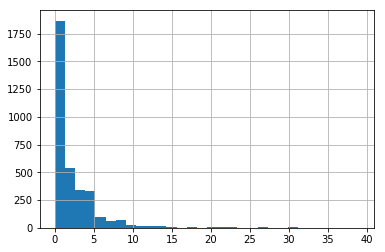

In [34]:
y_train.hist(bins=30)


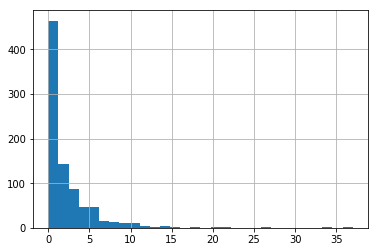

In [35]:
y_test.hist(bins=30)

In [36]:
def get_formula(columns):
    return 'msale ~ ' + " + ".join(columns)
col_list = train_df.columns.drop('msale')


In [37]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

est = smf.ols(get_formula(col_list),data=train_df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  msale   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     96.38
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:24:43   Log-Likelihood:                -10540.
No. Observations:                4290   AIC:                         2.113e+04
Df Residuals:                    4266   BIC:                         2.128e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1912      0.359      0.533      0.594      -0.512       0.894
shop_size         1.206e-05    2.8e-05      0.430      0.667   -4.29e-05     6.7e-05
work_time           -0.0105      0.019     -0.554      0.580      -0.048       0.027
total_sales          0.0017   9.61e-05     17.711      0.000       0.002       0.002
population        1.824e-08   3.71e-08      0.491      0.623   -5.45e-08     9.1e-08
salary_reg        2.034e-05   4.45e-06      4.573      0.000    1.16e-05    2.91e-05
mosque               0.2391      0.123      1.940      0.052      -0.002       0.481
muslim_per_reg       0.0924      0.008     11.801      0.000       0.077       0.108
religion_imp_reg     0.0041      0.012      0.342      0.733      -0.020       0.028
rus_per_reg         -0.0166      0.005     -3.667      0.000      -0.025      -0.008
type_ГМ             -0.3927      0.269     -1.462      0.144      -0.919       0.134
type_Рынок           1.0253      0.755      1.359      0.174      -0.454       2.505
type_Стрит          -0.4341      0.187     -2.322      0.020      -0.801      -0.068
type_ТРЦ             0.1690      0.199      0.850      0.395      -0.221       0.559
type_ТЦ             -0.1763      0.196     -0.902      0.367      -0.560       0.207
brand_a             -0.3525      0.153     -2.304      0.021      -0.652      -0.053
brand_ab            -0.4036      0.147     -2.744      0.006      -0.692      -0.115
brand_b              0.0287      0.140      0.204      0.838      -0.247       0.304
brand_silver         0.9187      0.313      2.932      0.003       0.304       1.533
district_ДФО        -0.4929      0.232     -2.122      0.034      -0.948      -0.037
district_ПФО         1.7002      0.129     13.145      0.000       1.447       1.954
district_СЗФО       -0.5208      0.178     -2.921      0.004      -0.870      -0.171
district_СКФО       -1.0380      0.197     -5.273      0.000      -1.424      -0.652
district_СФО        -0.0855      0.128     -0.667      0.505      -0.337       0.166
district_УФО         0.1903      0.162      1.176      0.240      -0.127       0.507
district_ЦФО         0.2456      0.154      1.597      0.110      -0.056       0.547
district_ЮФО         0.1923      0.122      1.575      0.115      -0.047       0.432
==============================================================================
Omnibus:                     3244.516   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           105073.163
Skew:                           3.290   Prob(JB):                         0.00
Kurtosis:                      26.335   Cond. No.                     9.37e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance m

Обучу модели вернув обратно название региона

In [38]:
train_df1 = raw_df.drop(['id','city','coord'], axis=1)
train_df1 = pd.get_dummies(train_df1)
train_df1.rename(columns={'925_msale':'msale'},inplace=True)

In [39]:
# обучаю разные модели регрессий
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, BayesianRidge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

X = train_df1.drop(['msale'],axis=1)
y = train_df1['msale']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# создаю объекты
lm = LinearRegression()
rg = Ridge(alpha=1)
ls = Lasso(alpha=1)
bs = BayesianRidge()
lr = LogisticRegression()

# тренирую модели
lm.fit(X_train, y_train)
rg.fit(X_train, y_train)
ls.fit(X_train, y_train)
bs.fit(X_train, y_train)
lr.fit(X_train, y_train)

#создаю предсказания
lm_y_pred = lm.predict(X_test)
rg_y_pred = rg.predict(X_test)
ls_y_pred = ls.predict(X_test)
bs_y_pred = bs.predict(X_test)
lr_y_pred = lr.predict(X_test)


C:\Users\Dotsenko.Semen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.035429e-17
  overwrite_a=True).T


In [40]:
#Метрики
print('Linear Regression R^2: %.2f' % r2_score(y_test, lm_y_pred))
print("Linear Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, lm_y_pred))

print('Ridge Regression R^2: %.2f' % r2_score(y_test, rg_y_pred))
print("Ridge Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, rg_y_pred))

print('Lasso Regression R^2: %.2f' % r2_score(y_test, ls_y_pred))
print("Lasso Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, ls_y_pred))

print('Bayesian Ridge Regression R^2: %.2f' % r2_score(y_test, bs_y_pred))
print("Bayesian Ridge Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, bs_y_pred))

print('Logistic Regression R^2: %.2f' % r2_score(y_test, lr_y_pred))
print("Logistic Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, lr_y_pred))

Linear Regression R^2: 0.41
Linear Regression Средний квадрат ошибки: 6.72
Ridge Regression R^2: 0.41
Ridge Regression Средний квадрат ошибки: 6.71
Lasso Regression R^2: 0.26
Lasso Regression Средний квадрат ошибки: 8.36
Bayesian Ridge Regression R^2: 0.41
Bayesian Ridge Regression Средний квадрат ошибки: 6.71
Logistic Regression R^2: -0.18
Logistic Regression Средний квадрат ошибки: 13.43


In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4290 entries, 0 to 8129
Data columns (total 27 columns):
msale               4290 non-null float32
shop_size           4290 non-null float32
work_time           4290 non-null float32
total_sales         4290 non-null float32
population          4290 non-null float32
salary_reg          4290 non-null float32
mosque              4290 non-null float32
muslim_per_reg      4290 non-null float32
religion_imp_reg    4290 non-null float32
rus_per_reg         4290 non-null float32
type_ГМ             4290 non-null float32
type_Рынок          4290 non-null float32
type_Стрит          4290 non-null float32
type_ТРЦ            4290 non-null float32
type_ТЦ             4290 non-null float32
brand_a             4290 non-null float32
brand_ab            4290 non-null float32
brand_b             4290 non-null float32
brand_silver        4290 non-null float32
district_ДФО        4290 non-null float32
district_ПФО        4290 non-null float32
district_СЗ

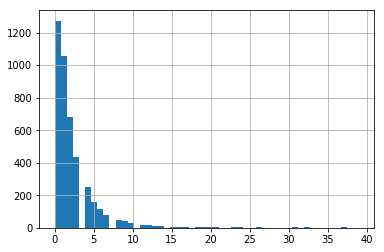

In [42]:
train_df['msale'].hist(bins=50)

Заменим ноль

In [43]:
train_df['msale'].describe()

count    4290.000000
mean        2.310723
std         3.481279
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        39.000000
Name: msale, dtype: float64

In [44]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4290 entries, 0 to 8129
Data columns (total 22 columns):
id                    4290 non-null float64
925_msale             4290 non-null float64
city                  4290 non-null object
type                  4290 non-null object
shop_size             4290 non-null float64
work_time             4290 non-null float64
total_sales           4290 non-null float64
stock_month           4290 non-null float64
brand                 4290 non-null object
population            4290 non-null float64
salary_reg            4290 non-null float64
salary_district       4290 non-null float64
mosque                4290 non-null float64
muslim_per_reg        4290 non-null float64
muslim_per_distr      4290 non-null float64
religion_imp_reg      4290 non-null float64
religion_imp_distr    4290 non-null float64
rus_per_reg           4290 non-null float64
rus_per_distr         4290 non-null float64
coord                 4290 non-null object
district         

In [45]:
# вместо города и региона создадим новые признаки: продажи/среднее по городу, продажи/среднее по региону, 
#продажи по региону/среднее по регионам

city_average = raw_df.groupby('city')['925_msale'].mean()
district_mean = raw_df.groupby('district')['925_msale'].mean()

raw_df['sales_to_citymean'] = raw_df['925_msale']/raw_df['city'].apply(lambda x: city_average.get(x))
raw_df['sales_to_distrmean'] = raw_df['925_msale']/raw_df['district'].apply(lambda x: district_mean.get(x))
raw_df['distrsales_to_mean'] = raw_df['925_msale']/raw_df['district'].apply(lambda x: district_mean.get(x))

In [46]:
raw_df.groupby('district')['925_msale'].mean()/raw_df['925_msale'].mean()

district
ДФО     0.532141
ПФО     2.020762
СЗФО    0.757339
СКФО    1.177419
СФО     0.603450
УФО     1.301087
ЦФО     0.710870
ЮФО     0.739889
Name: 925_msale, dtype: float64

In [47]:
raw_df['925_msale'].mean()

2.310722610722611

In [48]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4290 entries, 0 to 8129
Data columns (total 25 columns):
id                    4290 non-null float64
925_msale             4290 non-null float64
city                  4290 non-null object
type                  4290 non-null object
shop_size             4290 non-null float64
work_time             4290 non-null float64
total_sales           4290 non-null float64
stock_month           4290 non-null float64
brand                 4290 non-null object
population            4290 non-null float64
salary_reg            4290 non-null float64
salary_district       4290 non-null float64
mosque                4290 non-null float64
muslim_per_reg        4290 non-null float64
muslim_per_distr      4290 non-null float64
religion_imp_reg      4290 non-null float64
religion_imp_distr    4290 non-null float64
rus_per_reg           4290 non-null float64
rus_per_distr         4290 non-null float64
coord                 4290 non-null object
district         

In [54]:
# Преобразуем столбец coord для визуализации
import pandas as pd
def latitude(string):
    return float(string[1:-1].split(",")[0])

def longitude(string):
    return float(string[1:-1].split(",")[1])

raw_df['latitude'] = raw_df.coord.apply(latitude)
raw_df['longitude'] = raw_df.coord.apply(longitude)

In [56]:
from keplergl import KeplerGl
map_1 = KeplerGl()
map_1.add_data(data=raw_df, name='muslim')
map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'atjqj7qz', 'type':…